In [1]:
'''
Initializes python packages and give paths to appropriate files to be used like categories file,
the twitter file to be used alongwith the default stopword list (This is where our own created stoplist will be declared too).
'''
from __future__ import print_function
from IPython.display import display
import datetime, calendar, nltk, string, math, csv, glob, ntpath, os.path
import numpy as np
from gensim.models import Phrases
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer; wnl = WordNetLemmatizer()
import warnings, matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#from rirdc_lib_old import cleanUp, calculate_seed
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
import pandas as pd



path = r'C:\Users\n9553291\Documents' 
stopwords_file, categories_file = path+'\\stopwords.txt', path+'\\Category_DomainTerms.txt' # {(category, term)}
out_fname = path+'\\new_data_file.csv'
extra_cats_file=path+'\\extra_cats.txt'
#Give the wordnet path here
wordnet_path=path+'\\corpora\\wn-domains-3.2\\wn-domains-3.2-20070223'

n_topics, seed_ratio = 5, 0.25
max_df, min_df = 0.5, 0.1 # For the VSM
topic_groups=[]

def keywithmaxval(d):
    v=list(d.values());k=list(d.keys())
    return k[v.index(max(v))]

value=int(input("1 for twitter and 2 for patents"))
if value==1:
    data_file=path+'\\results-20170725-145833.csv'
elif value==2:
    data_file=path+'\\urlpatentout2017_1.csv'
print('Loading packages and file paths declarations done...')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:819: DeprecationWarning: invalid escape sequence \w
  if re.match('\w:', url) or re.match(r'\\', url):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:947: DeprecationWarning: invalid escape sequence \s
  if re.search('^\s', token) or re.search('\s$', token):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:947: DeprecationWarning: invalid escape sequence \s
  if re.search('^\s', token) or re.search('\s$', token):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:3650: DeprecationWarning: invalid escape sequence \|
  elif re.match('(or|\|\|)', conditional):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:3880: DeprecationWarning: invalid escape s

1 for twitter and 2 for patents1
Loading packages and file paths declarations done...


In [2]:
#Creates a new file from the tweet file by getting rid of rows that are incomplete by appending their content to the 
#preceding row and deleting blank rows
test_file=open(data_file,encoding="ISO-8859-1")
twitter_file = open(out_fname, 'w',encoding="ISO-8859-1",newline='')
reader = csv.reader(test_file, delimiter=',')
writer = csv.writer(twitter_file)
next(reader, None)
for row in reader:
    if row[0] in (None, ""):
        continue
    for term in row[3]:
        if term.isalpha()==False:
            try:
                if math.isnan(float(term)):
                    print("Entered")
                    row[3]=row[3].replace(term,' ')
            except:
                    pass
        if ord(term) > 127:
            row[3]=row[3].replace(term,' ')
        wnl.lemmatize(term,'n')
    writer.writerow(row)
test_file.close()
twitter_file.close()
print('Done Creating the cleaned version of tweet file...')

Done Creating the cleaned version of tweet file...


In [3]:
# Loading the Wordnet domains.
s2d = []
for i in open(wordnet_path, 'r'):
    ssid, doms = i.strip().split('\t')
    doms = doms.split()
    for d in doms:
        s2d.append(d)
synset2domains=list(set(s2d))
extra_cats={}

for syn in synset2domains:
    try:
        p_list,c_list,categories=[],[],[]
        obj=wn.synset(syn+'.n.01')
        topics=obj.topic_domains()
        parents=obj.hypernyms()
        children=obj.hyponyms()
        domains= [ topic.lemma_names() for topic in topics ] 
        for sublist in domains:
            for item in sublist:
                    categories.append(str(item.replace('_',' ')))
        pwords = [ parent.lemma_names() for parent in parents ]
        for sublist in pwords:
            for item in sublist:
                    p_list.append(str(item.replace('_',' ')))
        cwords = [ child.lemma_names() for child in children]
        for sublist in cwords:
            for item in sublist:
                    c_list.append(str(item.replace('_',' ')))
        words=p_list+c_list
        if categories:
            for category in categories:
                extra_cats[category]=words
    except:
        pass

out_extra_cats = open(extra_cats_file, 'w')
for k in extra_cats.keys():
    for v in extra_cats[k]:
        out_extra_cats.write(k+", ")
        out_extra_cats.write(v+"\n")
out_extra_cats.close()
print("Done creating extra categories..")

Done creating extra categories..


In [4]:
#Tokenizes and remove stopwords from the tweet column of the data file for bigrams and unigrams --> For Months

input_file = open(out_fname,encoding="ISO-8859-1")
date_list,country_list=[],[]
reader = csv.reader(input_file, delimiter=',')

#Creates a unique list of months and countries from tweets
for row in reader:
    created_at,*rest=row[1].split(' ')           #splits the 'Created at' column to retrieve 'month'
    year,months,date=created_at.split('-')
    month=calendar.month_name[int(months)]
    if month not in date_list:
       date_list.append(str(month))
    
#Creates csv files with names after months
for month in date_list:
   outfile = open(path+'\Data{0:2s}'.format(str(month))+'.csv', 'w', newline='',encoding="ISO-8859-1")
   writer = csv.writer(outfile, delimiter = ',')
   writer.writerow(["tweet_id","month","text","country"])
   outfile.close()
    
#Shifts rows of tweets to their respective csv files  -->  For Months
for month1 in date_list:
  with open(out_fname, 'r',encoding="ISO-8859-1") as f:
    reader = csv.reader(f, delimiter=',')
    outfile = open(path+'\Data{0:2s}'.format(str(month1))+'.csv','a', newline='',encoding="ISO-8859-1")
    for row in reader:
        if row[0] in (None, ""):
          continue
        created_at,*rest=row[1].split(' ')  
        year,months,date=created_at.split('-')
        month2=calendar.month_name[int(months)]
        if month1==month2:
            writer = csv.writer(outfile, delimiter =',')
            writer.writerow(row)
    outfile.close()
print('Done moving tweets to their respective months and location files...')

<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence \D
<input>:17: DeprecationWarning: invalid escape sequence 

Done moving tweets to their respective months and location files...


In [5]:
#Tokenizes and remove stopwords from the tweet column of the data file for bigrams and unigrams --> For Months

df=open(stopwords_file,"r",encoding="ISO-8859-1", errors='replace')
stops=df.readlines(); df.close()
stops = set([word.strip() for word in stops])                  #stores stopwords tokens from the stoplist in a list
stops1=list(stops)
stops2=''.join(stops1)
tweet_id_m, text_m={},{}
tweet_id_c,text_c={},{}
docs,r=[],[]
sentences=[]
DocZ_m={} # will be used to find categories
for month in date_list:
    u,p,d=[],[],[]
    outfile = open(path+'\Data{0:2s}'.format(str(month))+'.csv', 'r', newline='',encoding="ISO-8859-1")
    reader = csv.reader(outfile, delimiter=',')
    next(reader,None)
    docs=list(reader);
    for doc in docs:    
        tmp = [t.strip() for t in doc]
        try:
            if len(tmp[3])>0: # Making sure not blanks
                sentence = [word
                    for word in nltk.word_tokenize(tmp[3].lower())
                    if word not in string.punctuation
                           and len(word)>3
                           ]
                filtered_word_list = sentence[:] #make a copy of the word_list
                for term in sentence: # iterate over word_list
                    if term in stops2: 
                        filtered_word_list.remove(term)
                sentences.append(filtered_word_list)                  #Bigrams List
                filtered=' '.join(filtered_word_list)
                u.append(tmp[0]); p.append(tmp[3]);d.append(filtered)
        except:
            pass
    tweet_id_m[month]=u
    text_m[month]=p 
    DocZ_m[month]=d
   
print("For the months found")
#print("The bigrams are -->", DocZ_m)

del docs
print("Clean-up for months done...,", end = ' ', flush = True)  

<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence 

For the months found
Clean-up for months done..., 

In [6]:
print("Please wait (it's going to take a while): Loading Data,", end = ' ', flush = True)
df=open(categories_file,"r",encoding="ISO-8859-1", errors='replace')
cats=df.readlines(); df.close(); categories = {}
for cat in cats:
     key = cat.split(', ')[0].strip(); term = cat.split(', ')[1].strip().lower()
     try:        
          categories[key].add(term)
     except:
          categories[key] = set([term])               #stores categories-terms as a key-value in a dictionary from the file
            
df=open(extra_cats_file,"r",encoding="ISO-8859-1", errors='replace')
cats=df.readlines(); df.close(); 
for cat in cats:
     key = cat.split(', ')[0].strip(); term = cat.split(', ')[1].strip().lower()
     try:        
          categories[key].add(term)
     except:
          categories[key] = set([term])               #stores categories-terms as a key-value in a dictionary from the file  
print("pre-Categories mapping ... ", flush = True)    
doc_cats_m,doc_cat_m = {}, {}; del cats, df
doc_cats_m_wob,doc_cat_m_wob={},{};
high_freq={}
for month in date_list:
   doc_cats_m[month],doc_cat_m[month],high_freq[month]={},{} ,{}
   for idx, doc in enumerate(DocZ_m[month]):
       notInCategories,total=[],0
       doc_cats_m[month][idx]={}
       for cat, terms in categories.items():
          for term in terms:
             n = doc.count(term)              #calculates the frequency of occurance of terms corresponding to terms for the category
             total+=n
             try:
                doc_cats_m[month][idx][cat] += n
             except:
                doc_cats_m[month][idx][cat]= n
       for cat, terms in categories.items():
            if total==0:
               doc_cat_m[month][idx] = None
               doc_cats_m[month][idx][cat] = 0.0
               if month not in notInCategories:
                  notInCategories.append(month)
            else:
             doc_cat_m[month][idx] = keywithmaxval(doc_cats_m[month][idx])           # category of doc[idx]
             doc_cats_m[month][idx][cat] = doc_cats_m[month][idx][cat]/total          # Normalizing to category's ratio
                
del doc
#print(doc_cat_m)
print('%d/%d Documents were not in any of the categories.' %(len(notInCategories), len(DocZ_m)), flush = True)

Please wait (it's going to take a while): Loading Data, pre-Categories mapping ... 
0/4 Documents were not in any of the categories.


In [7]:
#Calculates a score for each domain for each document in each month

topic_categories_freq, topic_categories_score = {}, {}
for month in date_list:
#topics_groups = [[1,12],[2,18],[3,7,9,14,15,19],[4],[5],[6,8,11],[10,13,16,17],[20]] # Change this depending on the visualization result; PS: this is "LDAtopic+1"
#topics_scores, seeds, seeds_score, clusters, centroids, mse = {}, {}, {}, {}, {}, {}
      topic_categories_freq[month], topic_categories_score[month] = {}, {}
      temp=[]  
      for k,v in doc_cat_m[month].items():
        C=doc_cat_m[month][k]
        temp.append(doc_cat_m[month][k])
        if C: #not None
            try:
                topic_categories_freq[month][C]+=1
                topic_categories_score[month][C]+=doc_cats_m[month][k][C]
            except:
                topic_categories_freq[month][C]=1
                topic_categories_score[month][C]=doc_cats_m[month][k][C]
        else:
            try:
                topic_categories_freq[month]['None']+=1
            except:
                topic_categories_freq[month]['None']=1  
      for k,v in categories.items():
        if k not in temp:
            topic_categories_freq[month][k]=0.0
            topic_categories_score[month][k]=0.0
    # Normalizing scores
      for C in topic_categories_freq[month].keys():
        if C is not 'None':
            N = topic_categories_freq[month][C]
            if N !=0:
                topic_categories_score[month][C] = topic_categories_score[month][C]/N
            else:
                topic_categories_score[month][C] = 0.0
      if topic_categories_freq[month]['agriculture'] == topic_categories_freq[month]['finance'] == topic_categories_freq[month]['mining'] == 0.0:
        topic_categories_freq[month]['None']=1 
      if topic_categories_score[month]['agriculture'] == topic_categories_score[month]['finance'] == topic_categories_score[month]['mining'] == 0.0:
        topic_categories_score[month]['None']=1 
#print(topic_categories_freq)
#print(topic_categories_score)
print ('Done assigning scores...')
    # doc_cats[idx][cat] ; 
    #seeds[str(topic)], seeds_score[str(topic)] = calculate_seed(dtm_tf,doc_topic,tf_terms,topic,categories,seed_ratio) # return Dictionary [categories]:{docs} ==> nested dict
    #clusters[str(topic)], centroids[str(topic)], mse[str(topic)] = ss_clustering(vsm_topics,seeds[str(topic)],doc_topic,topic) # k from len(seeds[str(topic)])

Done assigning scores...


For month July
Visualization based on Category frequency: 
['None', 'mining', 'computer', 'military', 'finance', 'architecture', 'industry', 'agriculture', 'business', 'science', 'dramaturgy', 'computing machine', 'computing device', 'data processor', 'electronic computer', 'information processing system', 'linguistics', 'meteorology', 'dramatic art', 'dramatics', 'theater', 'theatre', 'manufacture', 'armed forces', 'armed services', 'military machine', 'war machine', 'scientific discipline', 'mathematics', 'math', 'maths', 'drama', 'art', 'artistic creation', 'artistic production', 'commercial enterprise', 'business enterprise']


<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: Dep

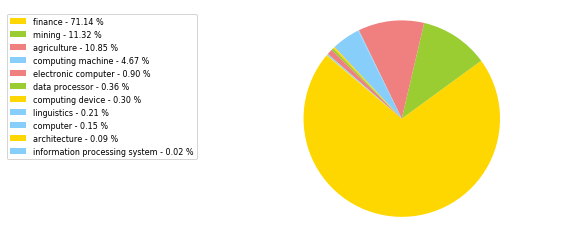

For month August
Visualization based on Category frequency: 
['None', 'computer', 'mining', 'finance', 'military', 'science', 'agriculture', 'architecture', 'industry', 'business', 'dramaturgy', 'computing machine', 'computing device', 'data processor', 'electronic computer', 'information processing system', 'linguistics', 'meteorology', 'dramatic art', 'dramatics', 'theater', 'theatre', 'manufacture', 'armed forces', 'armed services', 'military machine', 'war machine', 'scientific discipline', 'mathematics', 'math', 'maths', 'drama', 'art', 'artistic creation', 'artistic production', 'commercial enterprise', 'business enterprise']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


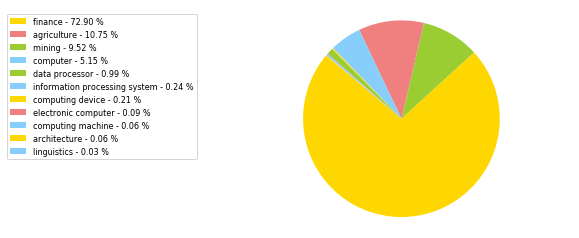

For month September
Visualization based on Category frequency: 
['None', 'mining', 'computer', 'finance', 'agriculture', 'science', 'architecture', 'industry', 'business', 'dramaturgy', 'military', 'computing machine', 'computing device', 'data processor', 'electronic computer', 'information processing system', 'linguistics', 'meteorology', 'dramatic art', 'dramatics', 'theater', 'theatre', 'manufacture', 'armed forces', 'armed services', 'military machine', 'war machine', 'scientific discipline', 'mathematics', 'math', 'maths', 'drama', 'art', 'artistic creation', 'artistic production', 'commercial enterprise', 'business enterprise']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


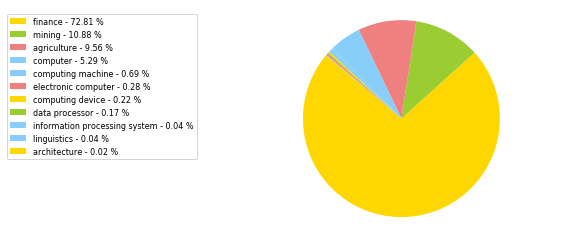

For month October
Visualization based on Category frequency: 
['None', 'mining', 'computer', 'finance', 'dramaturgy', 'agriculture', 'industry', 'science', 'business', 'military', 'architecture', 'computing machine', 'computing device', 'data processor', 'electronic computer', 'information processing system', 'linguistics', 'meteorology', 'dramatic art', 'dramatics', 'theater', 'theatre', 'manufacture', 'armed forces', 'armed services', 'military machine', 'war machine', 'scientific discipline', 'mathematics', 'math', 'maths', 'drama', 'art', 'artistic creation', 'artistic production', 'commercial enterprise', 'business enterprise']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


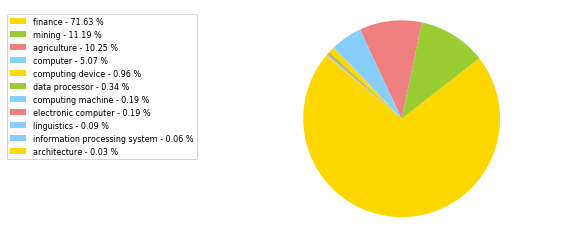

Done Visualising and saving pie charts...


In [8]:
#Creates a pie chart and saves it as a png file to be loaded later
import numpy as np
fileNameTemplate = path+'\Plot{0:2s}'
categoryy_list=categories.keys()
categoryy_list=list(categoryy_list)
for month in date_list:
     print("For month",month)
     print('Visualization based on Category frequency: ', flush = True)
     y=np.array(list(topic_categories_freq[month].values()))
     percent = 100.*y/y.sum()
     indices=np.where(percent == 0)[0].tolist()
     porcent=np.delete(percent,indices)
     np.asarray(categoryy_list)
     category_list=np.delete(categoryy_list,indices).tolist()
     labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(category_list, porcent)]
     print(list(topic_categories_freq[month].keys()))
     #labels = list(topic_categories_freq_c[country][str(topic)].keys())
     #print(labels)
     sizes = list(topic_categories_freq[month].values())
     colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','lightskyblue'][:len(labels)]
     explode = (0.1, 0, 0, 0)  # explode 1st slice: Change this anyway you like
     patches,text=plt.pie(sizes, colors=colors, startangle=140)
     plt.axis('equal')
     sort_legend = True
     if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                          key=lambda x: x[2],
                                          reverse=True))

     plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

     plt.savefig(fileNameTemplate.format(str(month)+'.png'), format='png', bbox_inches='tight')
     plt.show()
print('Done Visualising and saving pie charts...')

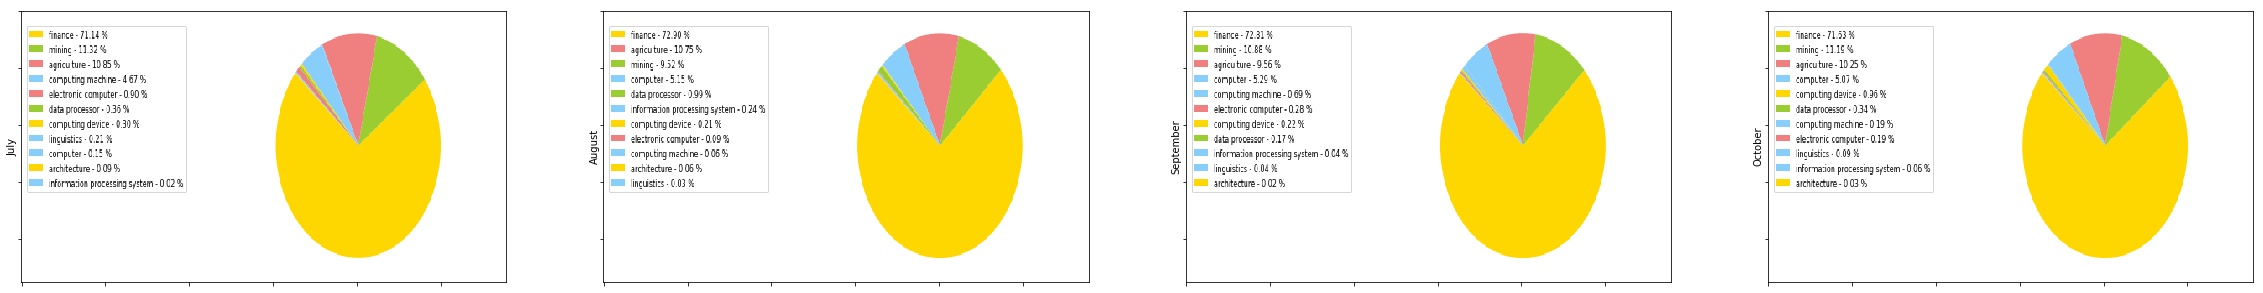

Done plotting for months...


In [9]:
#Loads back the saved png pie charts to be displayed over month-topic groups axes
import glob
import numpy as np
import ntpath
import matplotlib.image as mpimg
import os.path
n_clusters=5      #the one specified in kmm
fig, axarr = plt.subplots(nrows=1,ncols= len(date_list), sharex='col', sharey='row',  figsize=(40,5))
c=0   
for col in date_list:
      axarr[c].xaxis.set_label_position("top")
      axarr[c].set_ylabel(col)
      img=fileNameTemplate.format(str(col))+'.png'
      o=axarr[c].imshow(mpimg.imread(img),interpolation='nearest',aspect='auto')
      plt.setp(axarr[c].get_xticklabels(), visible=False)
      plt.setp(axarr[c].get_yticklabels(), visible=False)
      c+=1
plt.show()
print("Done plotting for months...")